## Data

### Download

In [1]:
import gdown
import os
import zipfile
import shutil

In [11]:
url = "https://drive.google.com/drive/folders/1PTA24UTZcsnzXPN1gmV0_lRg3lMHqwp6"
gdown.download_folder(url, quiet=False, use_cookies=False)

Retrieving folder list


Processing file 1AkJP4E7Wki5miKd6DW8JlW8xf6UfU1ud List.zip
Processing file 1IFDF7gyjnnyrns4Fm-Ui8sMloBsNY1EO Logo-2K+.zip
Processing file 1AnQh1-Ph7gHgw0e1afZVUwfsC5LRK4mb readme.txt
Processing file 1_WeyUnOig7QAkVtzbURG6J6si1k1QYHv train_and_test.zip
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1AkJP4E7Wki5miKd6DW8JlW8xf6UfU1ud
To: /home/yunho/Documents/CV/logo_similarity/Logo-2k+/List.zip
100%|██████████| 908k/908k [00:00<00:00, 4.04MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1IFDF7gyjnnyrns4Fm-Ui8sMloBsNY1EO
From (redirected): https://drive.google.com/uc?id=1IFDF7gyjnnyrns4Fm-Ui8sMloBsNY1EO&confirm=t&uuid=9b6ef4ed-9f37-4a2e-90c4-286d291e248f
To: /home/yunho/Documents/CV/logo_similarity/Logo-2k+/Logo-2K+.zip
100%|██████████| 1.57G/1.57G [01:41<00:00, 15.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AnQh1-Ph7gHgw0e1afZVUwfsC5LRK4mb
To: /home/yunho/Documents/CV/logo_similarity/Logo-2k+/readme.txt
100%|██████████| 1.71k/1.71k [00:00<00:00, 7.94MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1_WeyUnOig7QAkVtzbURG6J6si1k1QYHv
From (redirected): https://drive.google.com/uc?id=1_WeyUnOig7QAkVtzbURG6J6si1k1QYHv&

['/home/yunho/Documents/CV/logo_similarity/Logo-2k+/List.zip',
 '/home/yunho/Documents/CV/logo_similarity/Logo-2k+/Logo-2K+.zip',
 '/home/yunho/Documents/CV/logo_similarity/Logo-2k+/readme.txt',
 '/home/yunho/Documents/CV/logo_similarity/Logo-2k+/train_and_test.zip']

In [ ]:
dir_name = os.getcwd() + "/Logo-2k+"
new_dir_name = os.getcwd() + "/Data"

os.rename(dir_name, new_dir_name)

In [24]:
for filename in os.listdir(new_dir_name):
    if filename.endswith(".zip"):
        filepath = os.path.join(new_dir_name, filename)
        with zipfile.ZipFile(filepath, 'r') as zipObj:
            zipObj.extractall(new_dir_name)

In [26]:
def move_subclass_files(parent_folder):
    for class_name in os.listdir(parent_folder):
        class_path = os.path.join(parent_folder, class_name)

        # Only continue if this is a directory (a class)
        if os.path.isdir(class_path):
            for subclass_name in os.listdir(class_path):
                subclass_path = os.path.join(class_path, subclass_name)

                # Only continue if this is a directory (a subclass)
                if os.path.isdir(subclass_path):
                    new_name = f"{class_name}_{subclass_name}"
                    new_path = os.path.join(parent_folder, new_name)

                    # Create new directory in parent folder with the new name
                    os.makedirs(new_path, exist_ok=True)

                    # Move the contents of the subclass to the new directory
                    for file_name in os.listdir(subclass_path):
                        old_file_path = os.path.join(subclass_path, file_name)
                        new_file_path = os.path.join(new_path, file_name)
                        shutil.move(old_file_path, new_file_path)

                    # Delete the old empty subclass directory
                    os.rmdir(subclass_path)
            
            # Once all the subclasses for a class have been moved and deleted, remove the now-empty class directory
            os.rmdir(class_path)

In [27]:
parent_train_folder = os.getcwd()+'/Data/train_and_test/train/'
parent_test_folder = os.getcwd()+'/Data/train_and_test/test/'
print(parent_train_folder, parent_test_folder)

move_subclass_files(parent_train_folder)
move_subclass_files(parent_test_folder)

/home/yunho/Documents/CV/logo_similarity/Data/train_and_test/train/ /home/yunho/Documents/CV/logo_similarity/Data/train_and_test/test/


### Loader

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as utils
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder

from PIL import Image

import shutil
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import os

In [2]:
INPUT_SIZE = (224, 224) 

transform = transforms.Compose([
    transforms.Resize((600, 600), Image.BILINEAR),
    transforms.RandomResizedCrop(INPUT_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
    ])

### Custom Loader(from original code)

In [3]:
class GetLoader(Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.transform = transform
        self.data_root = data_root
        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.labels = []

        for data in data_list:
            image_path = data[:-1]
            label = image_path.split('/')[1]
            self.img_paths.append(image_path)
            self.labels.append(label)

    def __getitem__(self, item):
        img_path, label= self.img_paths[item], self.labels[item]
        # img_path_full = os.path.join(self.data_root, img_path)
        img_path_full = self.data_root+img_path
        img = Image.open(img_path_full).convert('RGB')
        # label = np.array(label,dtype='float32')
        label = int(label)-100
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return self.n_data

In [4]:
train_dataset = GetLoader(data_root = os.getcwd()+'/Data/Logo-2k+/', 
                        data_list = os.getcwd()+'/Data/List/train_images_root.txt',
                        transform = transform)

test_dataset = GetLoader(data_root = os.getcwd()+'/Data/Logo-2k/', 
                        data_list = os.getcwd()+'/Data/List/test_images_root.txt',
                        transform = transform)

In [5]:
print(len(train_dataset))
print(len(test_dataset))

116958
50182


### ImageFolder

In [3]:
train_imgfolder = ImageFolder(root = os.getcwd()+'/Data/train_and_test/train/',
                            transform = transform,
                            target_transform = None)

test_imgfolder = ImageFolder(root = os.getcwd()+'/Data/train_and_test/test/',
                             transform = transform)

In [4]:
print(train_imgfolder.classes)
print(train_imgfolder.class_to_idx)

['Accessories_24seven', 'Accessories_ALAN', 'Accessories_Ace', 'Accessories_Admiral', 'Accessories_Aetrex', 'Accessories_Agio', 'Accessories_Aim', 'Accessories_Akubra', 'Accessories_Alexia', 'Accessories_Allstar', 'Accessories_Artemide', 'Accessories_Ashbury', 'Accessories_Atlantic', 'Accessories_Atlantic Airlines', 'Accessories_Audar', 'Accessories_Aurora', 'Accessories_Avanti', 'Accessories_BACCARAT', 'Accessories_BAE', 'Accessories_BOSS', 'Accessories_BT', 'Accessories_Baba', 'Accessories_Baker Skateboards', 'Accessories_Balance', 'Accessories_Bandit', 'Accessories_Barcelo', 'Accessories_Basso', 'Accessories_Beeline', 'Accessories_Berghaus', 'Accessories_Berkshire', 'Accessories_Bexley', 'Accessories_Black Label Skateboards', 'Accessories_Black and Red', 'Accessories_Bobdog', 'Accessories_Bona', "Accessories_Boscov's", 'Accessories_Boxfresh', 'Accessories_Braun', 'Accessories_Bravo', 'Accessories_Breguet', 'Accessories_BridgePort', 'Accessories_Brooke', 'Accessories_Brooklyn', 'Acce

In [5]:
print(len(train_imgfolder.classes))

2341


In [6]:
print(len(train_imgfolder.imgs))
print(len(test_imgfolder.imgs))

116958
50182


In [7]:
train_imgloader = DataLoader(dataset = train_imgfolder,
                            batch_size = 256,
                            num_workers = 2,
                            shuffle = True)

test_imgloader = DataLoader(dataset = train_imgfolder,
                            batch_size = 256,
                            num_workers = 2,
                            shuffle = False)

### Visualization

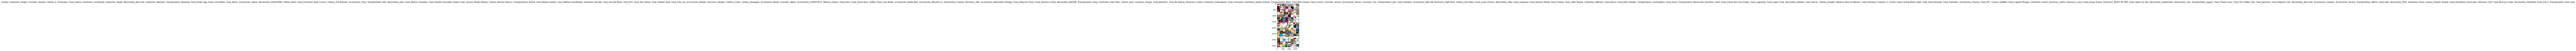

In [21]:
# Function to denormalize and bring back the image to original form
def denormalize(tensor):
    mean = torch.Tensor((0.485, 0.456, 0.406)).view(3, 1, 1)
    std = torch.Tensor((0.229, 0.224, 0.225)).view(3, 1, 1)
    return tensor * std + mean

# Get a batch of training data
inputs, classes = next(iter(train_imgloader))

# Make a grid from batch
inputs = denormalize(inputs)
out = utils.make_grid(inputs)

plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title('Classes: '+ ', '.join('%5s' % train_imgfolder.classes[classes[j]] for j in range(len(classes))))
plt.show()

ValueError: num must be an integer with 1 <= num <= 32, not 33

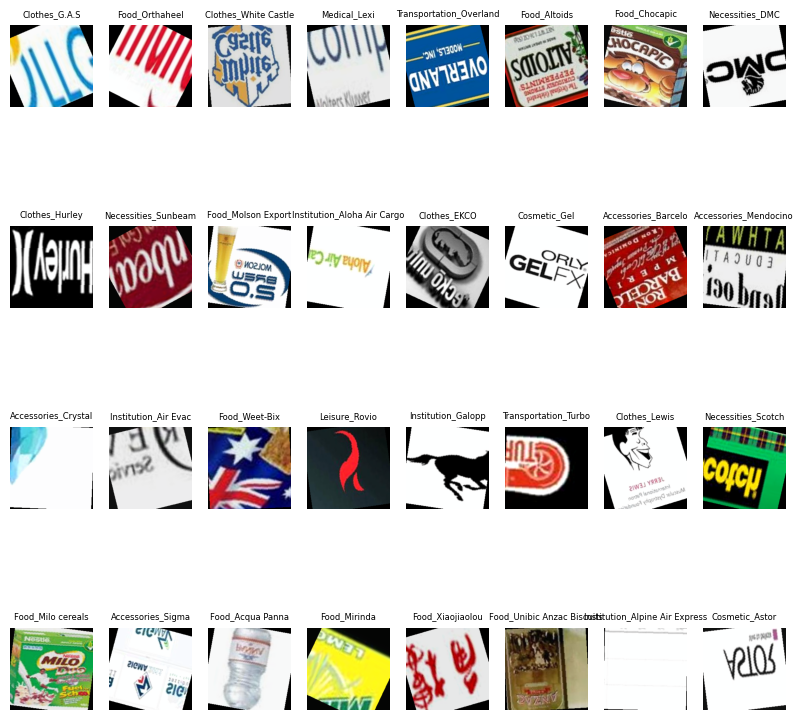

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(train_imgloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Denormalize images and plot
fig = plt.figure(figsize=(10,10))

for i in range(len(inputs)):
    fig.add_subplot(4, 8, i+1)
    imshow(inputs[i])
    plt.title(train_imgfolder.classes[classes[i]], fontsize=6)
    plt.axis('off')

plt.show()


## Model

### Model config

In [8]:
from transformers import AutoModelForImageClassification, ViTForImageClassification

model_ckpt = "google/vit-base-patch16-224-in21k"
extractor = AutoModelForImageClassification.from_pretrained(model_ckpt)
model = ViTForImageClassification.from_pretrained(model_ckpt)
model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=2341)

/home/yunho/anaconda3/envs/logo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the 

In [9]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [10]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.29.2"
}

### Fine-tuning

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print(f"Let's use {torch.cuda.device_count()} GPUs!")
  model = torch.nn.DataParallel(model)

model.to(device)

num_epochs = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250], gamma=0.1) # 학습률 감소

Let's use 2 GPUs!


In [12]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    tk0 = tqdm(dataloader, total=int(len(dataloader)))
    for images, labels in tk0:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.logits, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs.logits, labels)

            _, preds = torch.max(outputs.logits, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

def save_checkpoint(state, filename):
    torch.save(state, filename)

In [13]:
FILE_PATH = os.getcwd()

In [29]:
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

num_epochs = 1

best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    train_loss, train_acc = train_one_epoch(model, train_imgloader, optimizer, criterion, device)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    test_loss, test_acc = evaluate(model, test_imgloader, criterion, device)
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    # Save the model if it's the best one so far.
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        save_checkpoint({
            'epoch': epoch+1,
            'model_state_dict': best_model_wts,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict(),
            'best_acc': best_acc,
        }, os.path.join(FILE_PATH, 'Model', f'checkpoint_{epoch+1}.pth.tar'))
        print(f"Best model so far saved to checkpoint_{epoch+1}.pth.tar")

print("Training complete")

Epoch 1/1
----------


  0%|          | 0/457 [00:00<?, ?it/s]

100%|██████████| 457/457 [07:49<00:00,  1.03s/it]


Train Loss: 4.4397 Acc: 0.2333
Test Loss: 4.1043 Acc: 0.2716
Best model so far saved to checkpoint_1.pth.tar
Training complete


In [15]:
torch.cuda.empty_cache()

In [14]:
def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    
    return model, optimizer, scheduler, epoch, best_acc

In [30]:
CHECKPOINT_PATH = os.path.join(FILE_PATH, 'Model', 'checkpoint_35.pth.tar')
model, optimizer, scheduler, start_epoch, best_acc = load_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler)

In [31]:
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

num_epochs = start_epoch + 2

# Continue training.
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    train_loss, train_acc = train_one_epoch(model, train_imgloader, optimizer, criterion, device)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    test_loss, test_acc = evaluate(model, test_imgloader, criterion, device)
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        save_checkpoint({
            'epoch': epoch+1,
            'model_state_dict': best_model_wts,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict' : scheduler.state_dict(),
            'best_acc': best_acc,
        }, os.path.join(FILE_PATH, 'Model', f'checkpoint_{epoch+1}.pth.tar'))
        print(f"Best model so far saved to checkpoint_{epoch+1}.pth.tar")

print("Training complete")

Epoch 36/37
----------


100%|██████████| 457/457 [07:37<00:00,  1.00s/it]

Train Loss: 0.9687 Acc: 0.7866


Test Loss: 0.8295 Acc: 0.8200
Best model so far saved to checkpoint_36.pth.tar
Epoch 37/37
----------


 29%|██▉       | 133/457 [02:16<05:31,  1.02s/it]


KeyboardInterrupt: 

In [32]:
torch.cuda.empty_cache()

### Model comparison

In [19]:
# Load the original pre-trained model
from transformers import AutoModelForImageClassification, ViTForImageClassification

model_ckpt = "google/vit-base-patch16-224-in21k"
original_model = AutoModelForImageClassification.from_pretrained(model_ckpt)
original_model.classifier = torch.nn.Linear(in_features=original_model.classifier.in_features, out_features=2341)

# Assuming fine_tuned_model is your fine-tuned model
fine_tuned_model = model

# Get the state dict for both models
original_state_dict = original_model.state_dict()
fine_tuned_state_dict = fine_tuned_model.state_dict()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
print(original_state_dict.keys())

odict_keys(['vit.embeddings.cls_token', 'vit.embeddings.position_embeddings', 'vit.embeddings.patch_embeddings.projection.weight', 'vit.embeddings.patch_embeddings.projection.bias', 'vit.encoder.layer.0.attention.attention.query.weight', 'vit.encoder.layer.0.attention.attention.query.bias', 'vit.encoder.layer.0.attention.attention.key.weight', 'vit.encoder.layer.0.attention.attention.key.bias', 'vit.encoder.layer.0.attention.attention.value.weight', 'vit.encoder.layer.0.attention.attention.value.bias', 'vit.encoder.layer.0.attention.output.dense.weight', 'vit.encoder.layer.0.attention.output.dense.bias', 'vit.encoder.layer.0.intermediate.dense.weight', 'vit.encoder.layer.0.intermediate.dense.bias', 'vit.encoder.layer.0.output.dense.weight', 'vit.encoder.layer.0.output.dense.bias', 'vit.encoder.layer.0.layernorm_before.weight', 'vit.encoder.layer.0.layernorm_before.bias', 'vit.encoder.layer.0.layernorm_after.weight', 'vit.encoder.layer.0.layernorm_after.bias', 'vit.encoder.layer.1.atten

In [22]:
print(fine_tuned_state_dict.keys())

odict_keys(['module.vit.embeddings.cls_token', 'module.vit.embeddings.position_embeddings', 'module.vit.embeddings.patch_embeddings.projection.weight', 'module.vit.embeddings.patch_embeddings.projection.bias', 'module.vit.encoder.layer.0.attention.attention.query.weight', 'module.vit.encoder.layer.0.attention.attention.query.bias', 'module.vit.encoder.layer.0.attention.attention.key.weight', 'module.vit.encoder.layer.0.attention.attention.key.bias', 'module.vit.encoder.layer.0.attention.attention.value.weight', 'module.vit.encoder.layer.0.attention.attention.value.bias', 'module.vit.encoder.layer.0.attention.output.dense.weight', 'module.vit.encoder.layer.0.attention.output.dense.bias', 'module.vit.encoder.layer.0.intermediate.dense.weight', 'module.vit.encoder.layer.0.intermediate.dense.bias', 'module.vit.encoder.layer.0.output.dense.weight', 'module.vit.encoder.layer.0.output.dense.bias', 'module.vit.encoder.layer.0.layernorm_before.weight', 'module.vit.encoder.layer.0.layernorm_befo

In [24]:
for param_tensor in original_state_dict:
    # Adjust for the module prefix
    param_tensor_fine_tuned = 'module.' + param_tensor

    # Check if the parameter exists in both models
    if param_tensor_fine_tuned in fine_tuned_state_dict:
        # Move tensors to CPU and compare
        if not torch.all(torch.eq(original_state_dict[param_tensor].cpu(), fine_tuned_state_dict[param_tensor_fine_tuned].cpu())):
            print(f'Difference found in {param_tensor}')
    else:
        print(f'Parameter {param_tensor} not found in trained model')

Difference found in vit.embeddings.cls_token
Difference found in vit.embeddings.position_embeddings
Difference found in vit.embeddings.patch_embeddings.projection.weight
Difference found in vit.embeddings.patch_embeddings.projection.bias
Difference found in vit.encoder.layer.0.attention.attention.query.weight
Difference found in vit.encoder.layer.0.attention.attention.query.bias
Difference found in vit.encoder.layer.0.attention.attention.key.weight
Difference found in vit.encoder.layer.0.attention.attention.key.bias
Difference found in vit.encoder.layer.0.attention.attention.value.weight
Difference found in vit.encoder.layer.0.attention.attention.value.bias
Difference found in vit.encoder.layer.0.attention.output.dense.weight
Difference found in vit.encoder.layer.0.attention.output.dense.bias
Difference found in vit.encoder.layer.0.intermediate.dense.weight
Difference found in vit.encoder.layer.0.intermediate.dense.bias
Difference found in vit.encoder.layer.0.output.dense.weight
Differ

In [28]:
original_model.classifier.weight

Parameter containing:
tensor([[ 0.0078,  0.0179, -0.0153,  ...,  0.0107,  0.0331,  0.0081],
        [-0.0247,  0.0183, -0.0284,  ..., -0.0094, -0.0184, -0.0096],
        [-0.0092,  0.0159, -0.0109,  ..., -0.0339,  0.0116, -0.0149],
        ...,
        [-0.0236, -0.0050,  0.0312,  ..., -0.0030, -0.0013, -0.0028],
        [-0.0128,  0.0252,  0.0327,  ..., -0.0247,  0.0270, -0.0167],
        [ 0.0004, -0.0084, -0.0254,  ..., -0.0054,  0.0306,  0.0210]],
       requires_grad=True)

In [27]:
model.module.classifier.weight

Parameter containing:
tensor([[ 0.0436,  0.1708, -0.1558,  ..., -0.1014, -0.0167,  0.2819],
        [-0.0489, -0.2763,  0.0055,  ..., -0.2595,  0.1765, -0.1598],
        [ 0.1159,  0.1520, -0.1250,  ...,  0.0024,  0.2091, -0.0915],
        ...,
        [ 0.0929,  0.0536,  0.0468,  ..., -0.1365,  0.2416,  0.0862],
        [ 0.0333, -0.1471, -0.0366,  ...,  0.0034,  0.1002,  0.0951],
        [-0.0927, -0.0058,  0.1259,  ...,  0.1478,  0.1258, -0.0285]],
       device='cuda:0', requires_grad=True)

# Pipeline

## Model

In [29]:
model.module.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.29.2"
}

In [40]:
hidden_dim = model.module.config.hidden_size
image_size = model.module.config.image_size

print(hidden_dim)
print(image_size)

768
224


In [92]:
train_imgfolder

Dataset ImageFolder
    Number of datapoints: 116958
    Root location: /home/yunho/Documents/CV/logo_similarity/Data/train_and_test/train/
    StandardTransform
Transform: Compose(
               Resize(size=(600, 600), interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [95]:
def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for img_batch, _ in dataloader: # extract images and labels
            img_batch = img_batch.to(device) # move to device, batch dimension already present
            outputs = model(img_batch)
            logits = outputs.logits
            embeddings.append(logits.cpu().numpy())
    return embeddings

embeddings = extract_embeddings(train_imgloader, model)

In [107]:
print(len(embeddings))
print(embeddings[0].shape)

457
(256, 2341)


In [ ]:
from tqdm.auto import tqdm

candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]
    
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry) # id와 label을 합쳐서 candidate_ids에 저장

100%|██████████| 1000/1000 [00:02<00:00, 369.40it/s]


In [ ]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"]) # feature를 numpy array로 변환
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings) # numpy array를 torch tensor로 변환

In [ ]:
def compute_scores(emb_one, emb_two):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    # 이미지 전처리
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # 이미지에 대한 embedding 추출
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # 이미지와 가장 유사한 이미지를 찾기 위해 코사인 유사도 계산
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # 코사인 유사도가 높은 순으로 정렬
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

In [ ]:
test_idx = np.random.choice(len(dataset["test"])) # test set에서 랜덤하게 샘플을 선택
test_sample = dataset["test"][test_idx]["image"] # 선택된 샘플의 이미지
test_label = dataset["test"][test_idx]["labels"] # 선택된 샘플의 라벨

sim_ids, sim_labels = fetch_similar(test_sample) # 선택된 샘플과 유사한 샘플을 찾아 id와 label을 반환
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 1
Top 5 candidate labels: [1, 1, 1, 1, 1]


In [ ]:
label2id, id2label = dict(), dict() # label을 id로 변환하는 딕셔너리

for i, label in enumerate(labels):
    label2id[label] = i # label을 id로 변환
    id2label[i] = label # id를 label로 변환

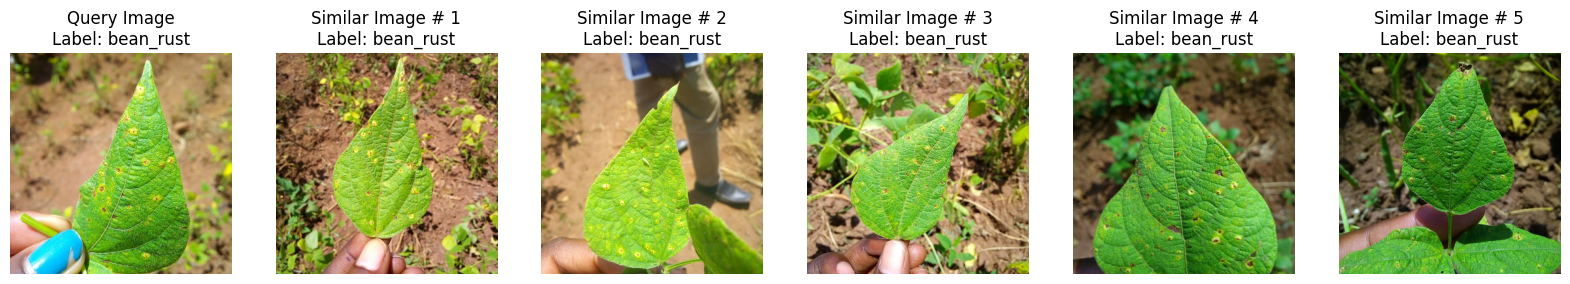

In [ ]:
import matplotlib.pyplot as plt
import math


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(math.ceil(len(images) / columns) + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)